In [2]:
import pandas as pd
from scipy.optimize import fsolve
import numpy as np
import itertools
import copy
from cyipopt import minimize_ipopt
import warnings
import matplotlib.pyplot as plt
from jax.config import config
# Enable 64 bit floating point precision
config.update("jax_enable_x64", True)

# We use the CPU instead of GPU und mute all warnings if no GPU/TPU is found.
config.update('jax_platform_name', 'cpu')

# import jax.numpy as np
from jax import jit, grad, jacfwd, jacrev
from tqdm.contrib.telegram import tqdm, trange
from dotenv import load_dotenv
import os

from bob_telegram_tools.bot import TelegramBot
load_dotenv()
import pyreadr
import numpy as np
import pickle
import pandas as pd
import statsmodels.api as sm

In [4]:
# without migrants
non_migration = {name:np.array(pyreadr.read_r(f"{name}_non_migration.Rda")[f"{name}_nm"]) 
                 for name in ["N_female", "N_male"]}
demography_in_model = np.array([[val if (111-g+t <=80) and (111-g+t>20) else 0 for g, val in enumerate(row)]
 for t,row in enumerate(non_migration['N_female'])])
Pi = (demography_in_model/demography_in_model.max(axis=0))
Pi_female = Pi[:,(96-65):-20].transpose()
demography_in_model = np.array([[val if (111-g+t <=80) and (111-g+t>20) else 0 for g, val in enumerate(row)]
 for t,row in enumerate(non_migration['N_male'])])
Pi = (demography_in_model/demography_in_model.max(axis=0))
Pi_male = Pi[:,(96-65):-20].transpose()
Pi = np.array([Pi_female, Pi_male])
with_migration = {name:np.array(pyreadr.read_r(f"{name}.Rda")[f"{name}"]) 
                 for name in ["N_female", "N_male"]}
N_female = np.array([[val if (111-g+t <=80) and (111-g+t>20) else 0 for g, val in enumerate(row)]
 for t,row in enumerate(with_migration['N_female'])])[:,(96-65):-20].transpose()
N_male = np.array([[val if (111-g+t <=80) and (111-g+t>20) else 0 for g, val in enumerate(row)]
 for t,row in enumerate(with_migration['N_male'])])[:,(96-65):-20].transpose()
N = np.array([N_female, N_male])


/tmp/ipykernel_4261/3326181543.py:6: RuntimeWarning: invalid value encountered in true_divide
  Pi = (demography_in_model/demography_in_model.max(axis=0))
/tmp/ipykernel_4261/3326181543.py:10: RuntimeWarning: invalid value encountered in true_divide
  Pi = (demography_in_model/demography_in_model.max(axis=0))


In [5]:
# df_wage = pd.read_excel("rosstat/wage_by_cohort.xlsx")
# df_wage_ext = pd.DataFrame([(1,(i-20),(i-20)**2,df_wage['wage'][df_wage['age']<=i].iloc[-1])
#                             for i in range(20,81)], columns = ['intercept','age','agesq','wage'])
# df_wage_ext['wage']=np.log(df_wage_ext['wage']/max(df_wage_ext['wage']))
# model = sm.OLS(df_wage_ext['wage'], df_wage_ext[['intercept','age','agesq']]).fit()

In [6]:
# plt.plot(np.exp(model.predict()), label=r"$\epsilon$")
# plt.plot(np.exp(df_wage_ext['wage']), label = "Средняя з/п, 2015 г.")
# plt.xlabel('Возраст')
# plt.legend()
# plt.savefig('plots/epsilon.pdf')

In [7]:
# n_generations=60
# epsilon_female =epsilon_male= np.array([[np.exp(model.params[2]*(n_generations-g+t)**2+
#                                                 model.params[1]*(n_generations-g+t)+
#                                                model.params[0])\
#                                          if ((n_generations-g+t) > 0 and (n_generations-g+t)<=n_generations) \
#                                          else 0  for t in range(N_female.shape[1]) ] \
#                                         for g in range(N_female.shape[0])])
# epsilon = np.array([epsilon_female, epsilon_male])

# rho_female = np.array([[1 if ((n_generations-g+t) >= 30 and (n_generations-g+t)<=n_generations) else 0
#                         for t in range(N_female.shape[1]) ] 
#                        for g in range(N_female.shape[0])])
# rho_male = np.array([[1 if ((n_generations-g+t) >= 35 and (n_generations-g+t)<=n_generations) else 0
#                       for t in range(N_female.shape[1]) ] 
#                      for g in range(N_female.shape[0])])

# rho = np.array([rho_female, rho_male])
# rho_female_reform = pd.read_csv("rho_female.csv", sep=',',header=None).to_numpy()
# rho_male_reform = pd.read_csv("rho_male.csv", sep=',',header=None).to_numpy()
# rho_reform = np.array([rho_female_reform, rho_male_reform])
# demography = {"N":N, "Pi":Pi, "epsilon":epsilon,"rho":rho,"rho_reform":rho_reform}
# epsilon_coef = np.sum(demography["N"][:,:,0])/np.sum(demography["N"][:,:,0]*demography["epsilon"][:,:,0])
# demography["epsilon"]*=epsilon_coef
# np.save('demography.npy', demography)

In [20]:
# # rho_female_reform = np.array([[1 if ((n_generations-g+t) >= 40 and (n_generations-g+t)<=n_generations) else 0
#                         for t in range(N_female.shape[1]) ] 
#                        for g in range(N_female.shape[0])])
# # rho_male_reform = np.array([[1 if ((n_generations-g+t) >= 45 and (n_generations-g+t)<=n_generations) else 0
#                       for t in range(N_female.shape[1]) ] 
#                      for g in range(N_female.shape[0])])
# import pandas as pd
# # pd.DataFrame(rho_female_reform).to_csv("rho_female.csv", header=False, index=False)
# import pandas as pd
# # pd.DataFrame(rho_male_reform).to_csv("rho_male.csv", header=False, index=False)

In [177]:
# from olg import *
# olg = OLG_model(G=60,T=250,N=N,epsilon=epsilon, rho=rho,
#                 gov_ratio=0.2,
#                 sigma = sigma,Pi=Pi,r = r,price_M =price_M,
#                 price_E=price_E, tau_I=tau_I,tau_II=tau_II,tau_Ins=tau_Ins,
#                 tau_pi=tau_pi, tau_VA=tau_VA, tau_rho=tau_rho, beta = 0.99,
#                 theta =1,
#                 phi =0.23, # цель 38 миллионов в стеди стейт или 65% в начальном положении
#                 psi = 24.
#                 , omega=0.269
#                 , gov_const = gov_const
#                 , alpha = 0.35, delta=0.0608,
#                 A=A,initial=initial, Oil=Oil,eta =0.05,steady_max_iter=5000,max_iter=5000,
#                 steady_guess=steady_guess)


# niter = 30
# tol = 10e-5
             

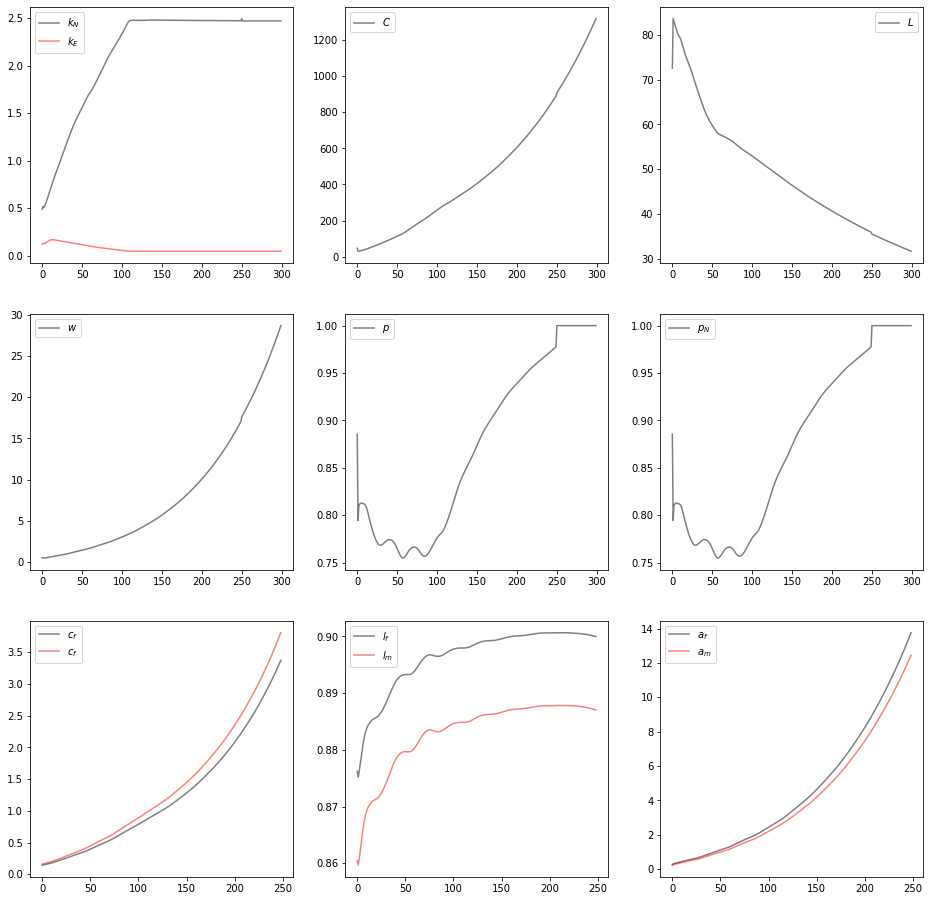

In [26]:
with open('olg_base_with_assets.file', 'rb') as f:
    olg=pickle.load(f)
fig, ax = plt.subplots(3,3, figsize = (16,16))
ax[0,0].plot(olg.k[0,:(olg.T+50)], alpha=0.5, color="black", label = r"$k_N$")
ax[0,0].plot(olg.k[1,:(olg.T+50)], alpha=0.5, color="red", label = r"$k_E$")
ax[0,1].plot(olg.Consumption[:(olg.T+50)], alpha=0.5, color="black", label = r"$C$")
ax[0,2].plot(olg.Labor[:(olg.T+50)], alpha=0.5, color="black", label = r"$L$")
ax[1,0].plot(olg.w[:(olg.T+50)], alpha=0.5, color="black", label = r"$w$")
ax[1,1].plot(olg.price[:(olg.T+50)], alpha=0.5, color="black", label = r"$p$")
ax[1,2].plot(olg.price[:(olg.T+50)], alpha=0.5, color="black", label = r"$p_N$")
ax[2,0].plot(olg.c[0,:,1:(olg.T)].diagonal(-olg.G+1), alpha=0.5, color="black", label = r"$c_{f}$")
ax[2,0].plot(olg.c[1,:,1:(olg.T)].diagonal(-olg.G+1), alpha=0.5, color="red", label = r"$c_{f}$")
ax[2,1].plot(olg.l[0,:,1:(olg.T)].diagonal(-olg.G+1), alpha=0.5, color="black", label = r"$l_{f}$")
ax[2,1].plot(olg.l[1,:,1:(olg.T)].diagonal(-olg.G+1), alpha=0.5, color="red", label = r"$l_{m}$")
ax[2,2].plot(olg.a[0,:,1:(olg.T)].diagonal(-olg.G+1), alpha=0.5, color="black", label = r"$a_{f}$")
ax[2,2].plot(olg.a[1,:,1:(olg.T)].diagonal(-olg.G+1), alpha=0.5, color="red", label = r"$a_{m}$")


for row in ax:
    for col in row:
        col.legend()

In [22]:
# with open('olg_r.file', 'rb') as f:
# #     olg=pickle.load(f)

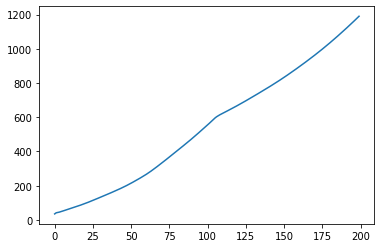

In [9]:
plt.plot(olg.K[0,:200])

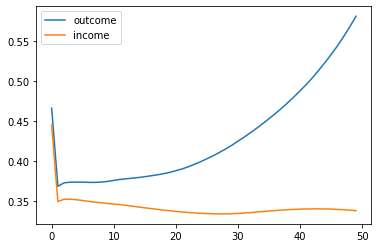

In [22]:
plt.plot(olg.Gov_Outcome[:50]/olg.GDP[:50], label="outcome")
plt.plot(olg.Gov_Income[:50]/olg.GDP[:50], label="income")
plt.legend()

In [25]:
olg.sigma

array([0.356, 0.356, 0.356, 0.356, 0.356, 0.356, 0.356, 0.356, 0.356,
       0.356, 0.356, 0.356, 0.356, 0.356, 0.356, 0.356, 0.356, 0.356,
       0.356, 0.356, 0.356, 0.356, 0.356, 0.356, 0.356, 0.356, 0.356,
       0.356, 0.356, 0.356, 0.356, 0.356, 0.356, 0.356, 0.356, 0.356,
       0.356, 0.356, 0.356, 0.356, 0.356, 0.356, 0.356, 0.356, 0.356,
       0.356, 0.356, 0.356, 0.356, 0.356, 0.356, 0.356, 0.356, 0.356,
       0.356, 0.356, 0.356, 0.356, 0.356, 0.356, 0.356, 0.356, 0.356,
       0.356, 0.356, 0.356, 0.356, 0.356, 0.356, 0.356, 0.356, 0.356,
       0.356, 0.356, 0.356, 0.356, 0.356, 0.356, 0.356, 0.356, 0.356,
       0.356, 0.356, 0.356, 0.356, 0.356, 0.356, 0.356, 0.356, 0.356,
       0.356, 0.356, 0.356, 0.356, 0.356, 0.356, 0.356, 0.356, 0.356,
       0.356, 0.356, 0.356, 0.356, 0.356, 0.356, 0.356, 0.356, 0.356,
       0.356, 0.356, 0.356, 0.356, 0.356, 0.356, 0.356, 0.356, 0.356,
       0.356, 0.356, 0.356, 0.356, 0.356, 0.356, 0.356, 0.356, 0.356,
       0.356, 0.356,

In [24]:
olg.Rho_sum-olg.sigma*olg.w*olg.rho[]

array([  6.70130098,   6.77528964,   6.88946212,   7.06859867,
         7.26288772,   7.45876016,   7.65715978,   7.8443199 ,
         8.03041294,   8.20820413,   8.37042454,   8.51760732,
         8.64464157,   8.77212413,   8.90546098,   9.03216101,
         9.1596479 ,   9.29466789,   9.43493273,   9.57809938,
         9.71790282,   9.86006216,  10.00554469,  10.15104244,
        10.29644482,  10.44357342,  10.58521531,  10.73310878,
        10.88451681,  11.0379998 ,  11.19600219,  11.35433521,
        11.51605812,  11.68077377,  11.84488101,  12.00976567,
        12.16662804,  12.32879542,  12.48896458,  12.65143066,
        12.81296898,  12.97166559,  13.1334332 ,  13.29857204,
        13.46227818,  13.62873596,  13.7856658 ,  13.95412402,
        14.1186764 ,  14.27565654,  14.43820297,  14.59784832,
        14.75763055,  14.91755246,  15.08672848,  15.26538001,
        15.44807883,  15.65606281,  15.88076926,  16.12849814,
        16.3804084 ,  16.64071038,  16.91227463,  17.19

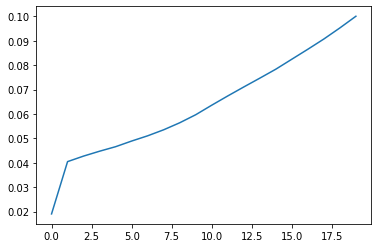

In [13]:
plt.plot(olg.Deficit_ratio[:20])

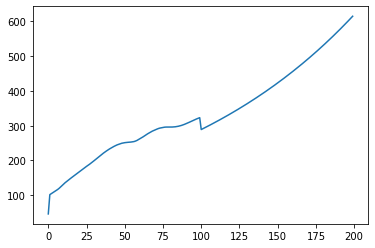

In [345]:
plt.plot(olg.Consumption[:200])#olg.Consumption[:10])

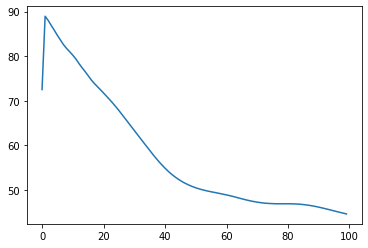

In [346]:
plt.plot(olg.Labor[:100])

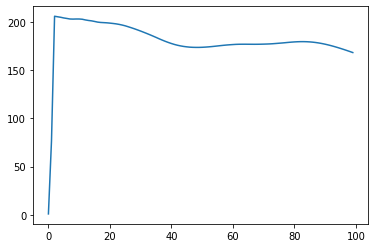

In [347]:
plt.plot(olg.GDP[:100])

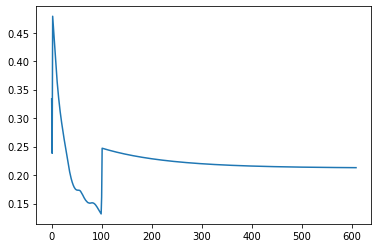

In [343]:
plt.plot(olg.Gov/olg.Consumption)

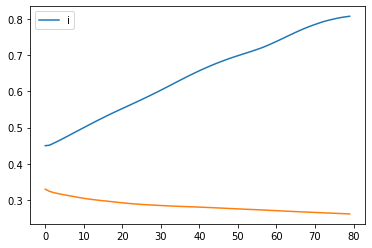

In [315]:
plt.plot(olg.Gov_Income[:80]/olg.GDP[:80], label="i")
plt.plot(olg.Gov[:80]/olg.GDP[:80])
plt.legend()

In [322]:
olg.VA_sum/olg.GDP

array([0.10790161, 0.1078912 , 0.10910434, 0.11059601, 0.1123182 ,
       0.1142798 , 0.11640828, 0.11872756, 0.12119946, 0.12378966,
       0.12645407, 0.12917744, 0.13191688, 0.13463913, 0.13737251,
       0.14012247, 0.14296768, 0.14577562, 0.14854346, 0.1513771 ,
       0.15421618, 0.15712031, 0.16011   , 0.16317295, 0.16631692,
       0.16956322, 0.17287471, 0.17635425, 0.1799782 , 0.18373689,
       0.18763993, 0.19164171, 0.1957737 , 0.20000266, 0.2042722 ,
       0.20856555, 0.21279166, 0.21704455, 0.22123457, 0.22538422,
       0.22944209, 0.23337726, 0.23724428, 0.24102725, 0.24467369,
       0.24822033, 0.25155013, 0.25489913, 0.25808851, 0.26110452,
       0.26412155, 0.26704899, 0.26996163, 0.27288722, 0.27596784,
       0.27922469, 0.28260836, 0.2864471 , 0.29060061, 0.29514293,
       0.29975035, 0.30446978, 0.30932384, 0.31425983, 0.31906345,
       0.32389243, 0.32847144, 0.33298777, 0.33717723, 0.34111337,
       0.34485782, 0.34844466, 0.35188164, 0.35484319, 0.35741

In [128]:
olg.Labor[0]

72.508

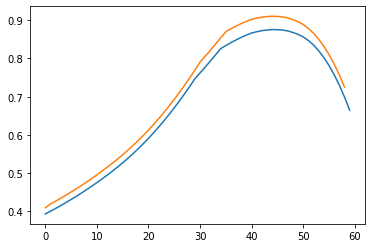

In [297]:
plt.plot(olg.c[:,59::-1,0].sum(axis=0))
plt.plot(olg.c[:,60:1:-1,1].sum(axis=0))

In [291]:
plt.olg.Consumption

array([   36.00754941,    37.49653777,    38.99871907,    40.48347414,
          42.04521184,    43.65901084,    45.38506219,    47.19178569,
          49.19623952,    51.33887349,    53.52311643,    55.69784226,
          57.77472726,    59.8956042 ,    62.08760459,    64.23690638,
          66.44363364,    68.74516546,    71.11602275,    73.55122721,
          75.97208439,    78.44411916,    80.97365531,    83.52122989,
          86.08775272,    88.6946451 ,    91.26999574,    93.97210336,
          96.76789261,    99.64557186,   102.63313456,   105.6740831 ,
         108.81204001,   112.0214195 ,   115.24475634,   118.4837164 ,
         121.62537309,   124.84914184,   128.05332341,   131.29643597,
         134.52684517,   137.72030084,   140.96362595,   144.24920278,
         147.5035767 ,   150.77142256,   153.88619957,   157.15583509,
         160.33153169,   163.37470474,   166.48928297,   169.54609971,
         172.60382365,   175.68072886,   178.9324424 ,   182.36291432,
      

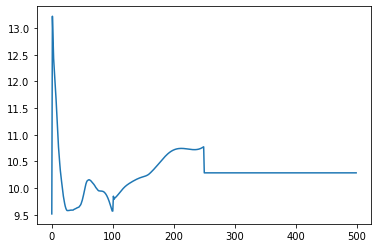

In [110]:
plt.plot(olg.Assets[:500]/olg.Consumption[:500])

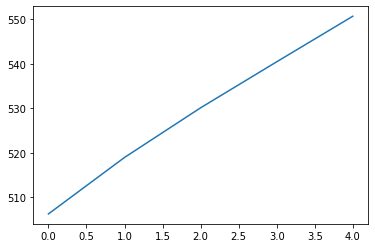

In [111]:
plt.plot(olg.Assets[:5])

In [281]:
olg.Deficit_ratio[0]

0.010261475561036083

In [ ]:
olg.

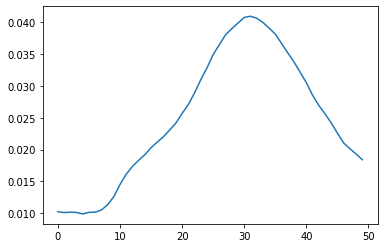

In [290]:
plt.plot(olg.Deficit_ratio[:50])

In [114]:
olg.Gov[0]

20.81693183982865

In [115]:
9.34471688-olg.GDP[0]/10

3.4004001482486554

In [25]:
olg.Gov

array([  20.81693184,   22.61592621,   23.62817006,   23.89868628,
         23.96582485,   24.04572384,   24.18173776,   24.36304636,
         24.61104039,   24.90753774,   25.22163825,   25.53611123,
         25.8263183 ,   26.1272396 ,   26.45296502,   26.77931107,
         27.11737826,   27.48465631,   27.8818203 ,   28.2983752 ,
         28.71993833,   29.15101627,   29.58978963,   30.02820413,
         30.46334871,   30.89577468,   31.31515865,   31.73690144,
         32.15874881,   32.57885862,   33.00065702,   33.41958098,
         33.83948116,   34.25956812,   34.67657042,   35.09282889,
         35.49919621,   35.91494599,   36.33541201,   36.76747877,
         37.20906303,   37.65897035,   38.12538254,   38.60999119,
         39.10665496,   39.61817838,   40.13015646,   40.66501801,
         41.2056679 ,   41.74477793,   42.29482901,   42.84683992,
         43.40048988,   43.95479476,   44.51805096,   45.08934308,
         45.66287029,   46.25639153,   46.86455068,   47.49107

In [12]:
(olg.Gov_Outcome[0]-olg.Gov_Income[0]-6.7)/olg.GDP[0]

-0.13382142957979107

In [13]:
olg.gov_const-6.5

-3.7

In [14]:
olg.Assets[250]/20

469.3266406145593

In [15]:
olg.Gov[0]

20.81693183982865

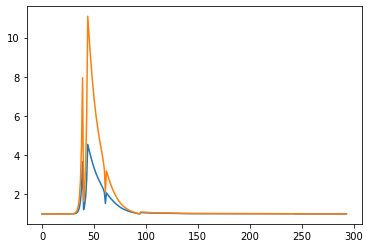

In [119]:
plt.plot(olg.price_N[6:300])
plt.plot(olg.price[6:300])

0.27215541623809786

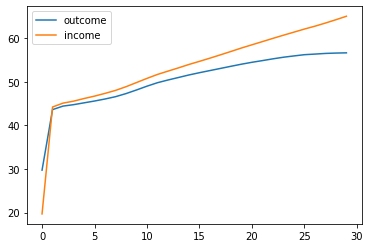

In [17]:
olg.Gov = 0.3195*(olg.Oil+olg.K[:,:].sum(axis=0))**olg.alpha*((olg.A[:,:]*olg.L[:,:]).sum(axis=0))**(1-olg.alpha)
for i in range(500):
    olg.update_government(i)
plt.plot(olg.Gov_Outcome[:30], label="outcome")
plt.plot(olg.Gov_Income[:30], label="income")
plt.legend()
# olg.Deficit[0]/olg.GDP[0]
olg.Debt[0]/olg.GDP[0]

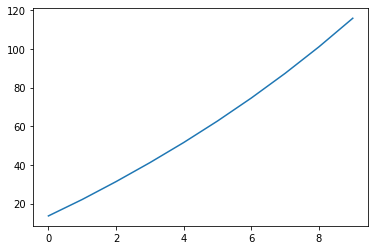

In [46]:
plt.plot(olg.Debt[:10])

In [519]:
(olg.Oil+olg.K[:,:].sum(axis=0))**olg.alpha*((olg.A[:,:]*olg.L[:,:]).sum(axis=0))**(1-olg.alpha)

array([   61.94845964,    67.38175278,    69.56719038,    72.29271419,
          75.01079076,    77.48127518,    79.84176192,    82.11381935,
          84.51980747,    87.04761391,    89.63061034,    92.21889177,
          94.70639263,    97.23071296,    99.79800725,   102.29387178,
         104.79226308,   107.3935942 ,   110.08477033,   112.83079942,
         115.58455932,   118.3728286 ,   121.17843039,   123.96047199,
         126.71034758,   129.43382171,   132.0702932 ,   134.71811615,
         137.35957978,   139.99832241,   142.66528684,   145.33318356,
         148.02778403,   150.74191268,   153.44938738,   156.15850173,
         158.8011524 ,   161.48540861,   164.16167611,   166.87965785,
         169.62631631,   172.39761835,   175.24277036,   178.16695618,
         181.13848604,   184.18411506,   187.20812584,   190.35687074,
         193.5052142 ,   196.62639567,   199.80332007,   202.96463778,
         206.126451  ,   209.2878025 ,   212.51372157,   215.80855773,
      

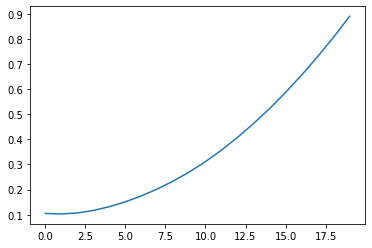

In [549]:
plt.plot((olg.Debt/olg.GDP)[:20])

In [529]:
olg.GDP = olg.Oil+\
        (olg.K[:,:].sum(axis=0))**olg.alpha*((olg.A[:,:]*olg.L[:,:]).sum(axis=0))**(1-olg.alpha)

In [384]:
olg.GDP[:] = (olg.Oil[:]+)

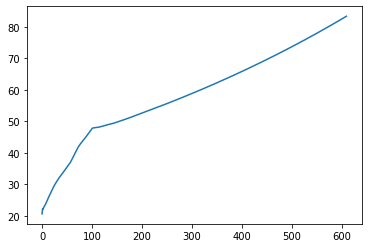

In [397]:
plt.plot(olg.GDP*0.30)

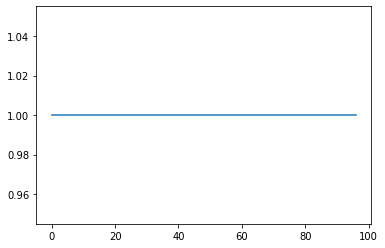

In [559]:
plt.plot(olg.GDP[3:100]/olg.GDP[2:99])

In [377]:
olg.Gov_Outcome[:10]

array([29.84059016, 31.14163894, 31.07363015, 31.06308823, 31.09174767,
       31.12022069, 31.18136445, 31.22319539, 31.37389891, 31.51766399])

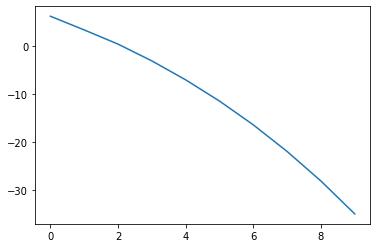

In [379]:
plt.plot(olg.Debt[:10])

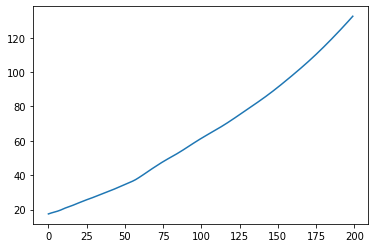

In [342]:
plt.plot(olg.Gov[:200])

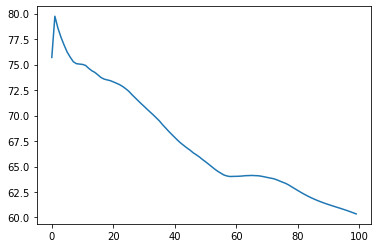

In [341]:
plt.plot(olg.Labor[:100])

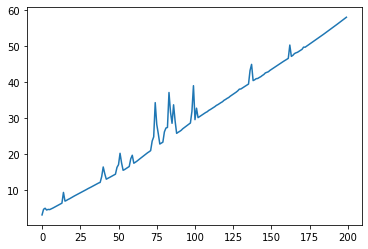

In [86]:
plt.plot(olg.I_sum[:200])

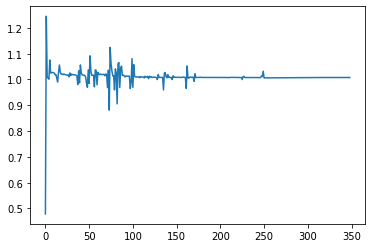

In [119]:
plt.plot(olg.Consumption[1:350]/olg.Consumption[:349])

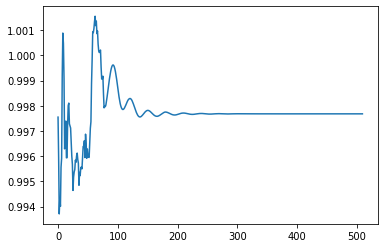

In [48]:
plt.plot(N[:,:,1:511].sum(axis=0).sum(axis=0)/N[:,:,:510].sum(axis=0).sum(axis=0))

In [15]:
Gov_init = olg.Gov_Income[0]-Debt_initial*olg.r[0]-\
np.sum(olg.sigma[0]*olg.rho[:,:,0]*olg.w[0]*olg.N[:,:,0])+GDP_initial*0.01069

In [358]:
Gov_init= 20.929656949411804

In [345]:
olg.Gov[0]=20.882747842555766

In [295]:
olg.Consumption[0]

42.57421319881056

In [296]:
GDP_initial

60.92091799485524

In [204]:
olg.price[0], olg.w[0], olg.

(1.3982259650479656, 0.5461272783231631)

In [195]:
olg.update_household(0)

In [154]:
olg.Consumption[0]

36.50522716560643

In [248]:
olg.K

array([[3.53593780e+01, 3.85165656e+01, 3.76650890e+01, ...,
        2.01876887e+04, 2.03422128e+04, 2.04979197e+04],
       [8.72962200e+00, 9.62803397e+00, 9.85395776e+00, ...,
        1.63777696e+04, 1.65031312e+04, 1.66294523e+04]])

In [202]:
olg.evaluate_initial_state()

In [251]:
olg.K[0,:]/olg.K[1,:]

array([4.05050505, 4.00046009, 3.82233108, 3.81119082, 3.75914166,
       3.69280281, 3.61641406, 3.56946561, 3.5017788 , 3.43144907,
       3.36073865, 3.29179319, 3.22548447, 3.16231808, 3.09856235,
       2.99517262, 2.93587255, 2.89608864, 2.86843707, 2.82957693,
       2.78949912, 2.74957759, 2.71053598, 2.6724295 , 2.63568499,
       2.60029081, 2.56625629, 2.53350883, 2.5020071 , 2.47197857,
       2.44258904, 2.41453798, 2.38745596, 2.36138246, 2.33623679,
       2.31200082, 2.28860211, 2.26595212, 2.24436894, 2.21308345,
       2.1935172 , 2.16700308, 2.15220053, 2.13731528, 2.12206542,
       2.10633836, 2.09046693, 2.07466397, 2.06030365, 2.0365721 ,
       2.0153106 , 2.00113296, 1.98225274, 1.97390133, 1.9652629 ,
       1.95439189, 1.94338818, 1.93192757, 1.91496671, 1.90363848,
       1.89238237, 1.87846397, 1.86861576, 1.86012422, 1.84891193,
       1.83853002, 1.82841579, 1.81796377, 1.80863583, 1.79933752,
       1.7906045 , 1.78165962, 1.77278474, 1.76014675, 1.75206

In [359]:
olg.Gov[0] = Gov_init
for i in range(1,max_time):
    g=A[0,i]/A[0,i-1]
    n=N[:,:,i].sum()/N[:,:,i-1].sum()
    olg.Gov[i] = olg.Gov[0] * n * g 

In [36]:
Gov_init

31.478394489017422

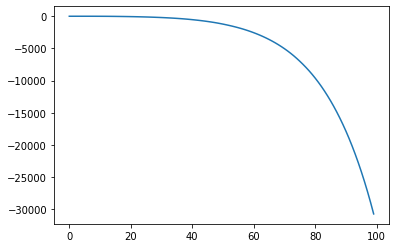

In [212]:
plt.plot(olg.Debt[:100])

In [200]:
Debt_initial

6.1231614676629

In [222]:
olg.Gov_Income[0]/olg.GDP[0]

0.4581979468051867

In [218]:
for i in range(1):
    olg.update_government(i)

In [93]:
olg.c[:,:,0]

array([[0.66855873, 0.76920576, 0.77706917, ..., 0.        , 0.        ,
        0.        ],
       [0.66927592, 0.73535654, 0.74049841, ..., 0.        , 0.        ,
        0.        ]])

In [220]:
olg.GDP

array([53.93029838, 66.37603274, 66.15273711, 65.80769822, 65.49997724,
       65.17534173, 64.93607898, 64.71732971, 64.67438806, 64.72187402,
       64.74755932, 64.69920798, 64.50124724, 64.32522327, 64.18717569,
       63.97229205, 63.75844078, 63.61354703, 63.50947812, 63.41075539,
       63.26934517, 63.12420228, 62.97499751, 62.79671271, 62.59088373,
       62.3692822 , 62.09569446, 61.85046167, 61.61661315, 61.38868068,
       61.18034974, 60.9688402 , 60.77090975, 60.57916176, 60.37574106,
       60.165806  , 59.91400416, 59.68827798, 59.45746786, 59.2430337 ,
       59.03082672, 58.8160003 , 58.62412122, 58.45326238, 58.28278856,
       58.1236999 , 57.93383917, 57.78814565, 57.62544452, 57.43647279,
       57.2652967 , 57.08272368, 56.89792489, 56.7133179 , 56.55707634,
       56.42616629, 56.30752362, 56.2571937 , 56.24858574, 56.29063218,
       56.33144437, 56.37947256, 56.44028523, 56.51059121, 56.56415928,
       56.62606256, 56.66538733, 56.70954103, 56.73028184, 56.73

In [89]:
olg.Assets[0]

35.78473433871407

In [88]:
olg.evaluate_initial_state()

75.51245356269779
75.51245356269779
75.51245356269779
75.51245356269779


In [91]:
for i in range(60):
    olg.update_guess(i)

KeyboardInterrupt: 

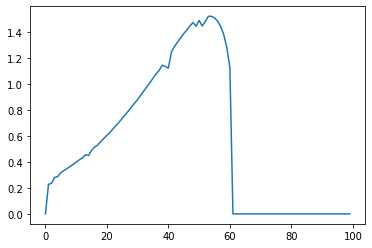

In [94]:
plt.plot(olg.c[0,60,:100])

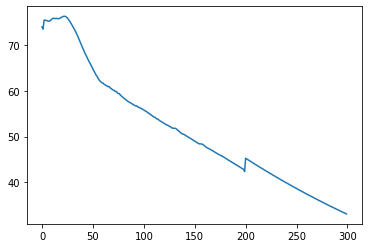

In [278]:
plt.plot(olg.Labor[:300])

In [313]:
k=3
olg.household(0,259-k,248-k,248-k)


(19.135572375153398, 0.40698405787412806, 112.9854178242148)

In [321]:
for i in range(50):
    print(olg.household(0,i,i,i))

(0.33797639292772474, 0.6284460601695301, -8.288725608651681e-17)
(0.4065989296062058, 0.6017041848618321, -0.00019998639063665072)
(0.40559495315142235, 0.6130353165222833, -0.00012211420039319465)
(0.41566847015930775, 0.6220127462263578, -5.082522916462044e-05)
(0.4277543539289345, 0.6257770105142018, -1.9537501436670858e-05)
(0.4392430674282758, 0.6298114351389041, 1.6725705278440237e-05)
(0.4503121905355077, 0.6335939925888409, 5.329265043458025e-05)
(0.46123955269128025, 0.6371809220746278, 9.046813060554701e-05)
(0.47205805343501706, 0.6404029017811265, 0.0001262914729231769)
(0.48293165152599715, 0.6433986396506117, 0.00016187706535619045)
(0.4939987028574387, 0.6462862342614104, 0.00019834123211695184)
(0.5052511277909633, 0.6491293144010538, 0.00023635592699548097)
(0.5167822183750947, 0.6519813636335496, 0.000276551178326305)
(0.5283965774252126, 0.6546806898969375, 0.0003169004108023177)
(0.539923612611278, 0.6573172286747899, 0.0003583743244046228)
(0.5513737325564985, 0.6

In [265]:
for i in range(olg.T):
    olg.update_guess(i)
    olg.update_household(i)
    print(i)

KeyboardInterrupt: 

In [260]:
olg.update_guess(1)
olg.update_household(1)

In [177]:
for i in range(2, olg.T):
    olg.update_guess(i)

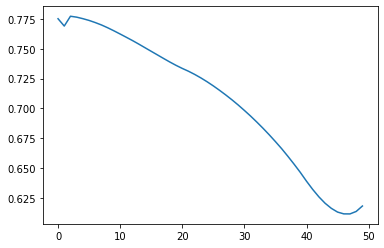

In [261]:
plt.plot(olg.l[0,50,:50])

In [262]:
olg.evaluate_initial_state()

74.08700174172273
74.08700174172273
74.08700174172273
74.08700174172273


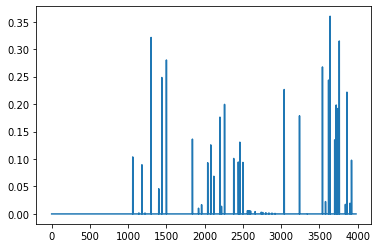

In [131]:
plt.plot([i['fun']  for key, item in olg.history.items()for i in item])

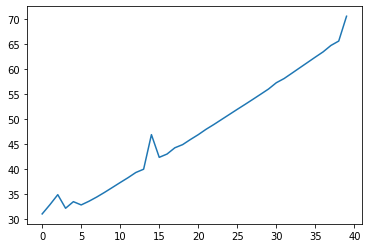

In [51]:
plt.plot(olg.Gov_Income[:40])

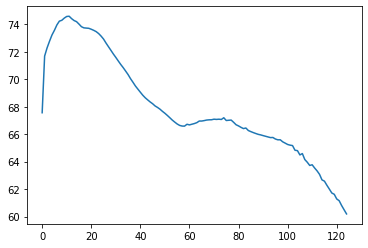

In [105]:
plt.plot(olg.Labor[0:125])

In [7]:
from olg import *
olg = OLG_model(G=60,T=250,N=N,epsilon=epsilon, rho=rho,
                sigma = sigma,Pi=Pi,r = r,price_M =price_M,
                price_E=price_E, tau_I=tau_I,tau_II=tau_II,tau_Ins=tau_Ins,
                tau_pi=tau_pi, tau_VA=tau_VA, tau_rho=tau_rho, beta = 0.99,
                theta =1,
                phi =0.23, # цель 38 миллионов в стеди стейт или 65% в начальном положении
                psi = 163.
                , omega=0.269
                , alpha = 0.35, delta=0.0608,
                A=A,initial=initial, Oil=Oil,eta =0.25,steady_max_iter=5000,max_iter=5000,
                steady_guess=steady_guess)

# Рисунки

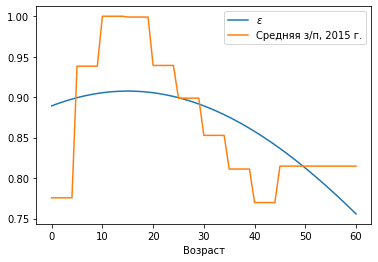

In [466]:
plt.plot(np.exp(model.predict()), label=r"$\varepsilon$")
plt.plot(np.exp(df_wage_ext['wage']), label = "Средняя з/п, 2015 г.")
plt.xlabel('Возраст')
plt.legend()
plt.savefig('plots/epsilon.pdf')

In [66]:
with_migration = {name:np.array(pyreadr.read_r(f"{name}.Rda")[f"{name}"]) 
                 for name in ["N_female", "N_male"]}

In [115]:
fact_pop =[None,146.267288, 146.544710, 146.804372, 146.880432, 146.780720,146.748590, 146.171015, 145.557576]

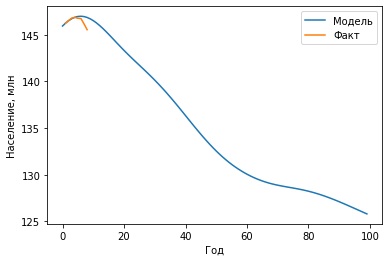

In [467]:
plt.plot((with_migration["N_female"].sum(axis=1)+with_migration["N_male"].sum(axis=1))[:100], label = "Модель")
plt.plot(fact_pop, label = 'Факт')
plt.ylabel('Население, млн')
plt.xlabel('Год')
plt.legend()
plt.savefig('plots/population.pdf')

In [235]:
retirement = np.array([[val*rho_reform[0,g-21,t] if 21<=111-g+t<=80 else if 111-g+t>=55 else 0 for t, val in enumerate(row)] 
                for g, row in enumerate(with_migration["N_female"].transpose())
])+np.array([[val if 111-g+t>=60 else 0 for t, val in enumerate(row)] 
                for g, row in enumerate(with_migration["N_male"].transpose())
])
children = np.array([[val if 111-g+t<=14 else 0 for t, val in enumerate(row)] 
                for g, row in enumerate(with_migration["N_female"].transpose())
])+np.array([[val if 111-g+t<=14 else 0 for t, val in enumerate(row)] 
                for g, row in enumerate(with_migration["N_male"].transpose())
])
other = np.array([[val if 14<111-g+t and 111-g+t<55 else 0 for t, val in enumerate(row)] 
                for g, row in enumerate(with_migration["N_female"].transpose())
])+np.array([[val if 14<111-g+t and 111-g+t<60  else 0 for t, val in enumerate(row)] 
                for g, row in enumerate(with_migration["N_male"].transpose())
])

In [309]:
with_migration["N_female"][0]#[110]

array([0.00001347, 0.00001735, 0.0000334 , 0.00006308, 0.00010641,
       0.00018183, 0.00037655, 0.00057663, 0.0011259 , 0.00171473,
       0.00284725, 0.00353337, 0.00448198, 0.00572808, 0.01323073,
       0.01517464, 0.02143673, 0.03336417, 0.05116378, 0.0801004 ,
       0.11233461, 0.14858007, 0.1950688 , 0.23646593, 0.29763842,
       0.3195546 , 0.3618669 , 0.35187664, 0.38457323, 0.33999364,
       0.37030299, 0.50305069, 0.60052404, 0.77352074, 0.80048684,
       0.81886029, 0.76230243, 0.71800097, 0.46493521, 0.30992065,
       0.33810023, 0.45331039, 0.74412667, 0.83256536, 0.85749887,
       1.04457471, 1.03078043, 1.04319802, 1.08593828, 1.07443917,
       1.1896331 , 1.19432378, 1.18097962, 1.21498834, 1.24636736,
       1.24574592, 1.32232155, 1.22978219, 1.17137421, 1.12068908,
       1.04322539, 1.01688478, 0.95982612, 0.92307314, 0.93426103,
       0.94442097, 1.0423272 , 1.00552556, 1.04578818, 1.04108534,
       1.07117383, 1.11699898, 1.10134952, 1.09099696, 1.12054

1.0

In [356]:
retirement_reform = np.array([[val if 111-g+t>=55 else 0 for t, val in enumerate(row)] 
                for g, row in enumerate(with_migration["N_female"].transpose())
])+np.array([[val if 111-g+t>=60 else 0 for t, val in enumerate(row)] 
                for g, row in enumerate(with_migration["N_male"].transpose())
])

In [357]:
N_total = with_migration["N_female"].transpose().sum(axis=0)+with_migration["N_male"].transpose().sum(axis=0)

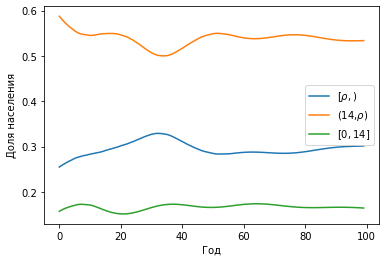

In [435]:
plt.plot((retirement.sum(axis=0)/N_total)[:100], label=r"$[\rho,)$")
plt.plot((other.sum(axis=0)/N_total)[:100], label=r"(14,$\rho)$")
plt.plot((children.sum(axis=0)/N_total)[:100], label=r"$[0,14]$")
plt.legend()
plt.ylabel('Доля населения')
plt.xlabel('Год')
# plt.title("Демографическая нагрузка, без реформы")
plt.savefig('plots/dependecy_ratio_bau.pdf')

In [424]:
rho_all_ages_wo_ref = np.array([[1 if 111-g+t>=55 else 0 for t, val in enumerate(row)] 
                for g, row in enumerate(with_migration["N_female"].transpose())
]),np.array([[1 if 111-g+t>=60 else 0 for t, val in enumerate(row)] 
                for g, row in enumerate(with_migration["N_male"].transpose())
])
rho_all_ages_ref = np.array([pd.read_csv("rho_female_test.csv", sep=',',header=None).to_numpy(),
                    pd.read_csv("rho_male_test.csv", sep=',',header=None).to_numpy()])

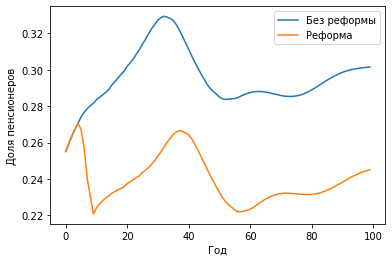

In [437]:
retirement = with_migration["N_female"].transpose()*rho_all_ages_wo_ref[0]+\
with_migration["N_male"].transpose()*rho_all_ages_wo_ref[1]
plt.plot((retirement.sum(axis=0)/N_total)[:100], label=r"Без реформы")
retirement_reform =(with_migration["N_female"].transpose()*rho_all_ages_ref[0])+\
(with_migration["N_male"].transpose()*rho_all_ages_ref[1])
plt.plot((retirement_reform.sum(axis=0)/N_total)[:100], label=r"Реформа")
plt.legend()
plt.ylabel('Доля пенсионеров')
plt.xlabel('Год')
plt.savefig('plots/dependecy_ratio_reform.pdf')

In [7]:
olg.update_a_initial()
olg.create_guess()

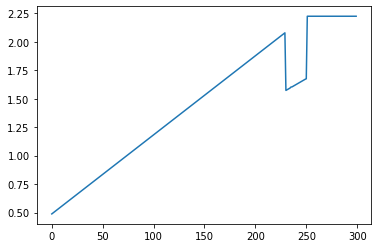

In [13]:
plt.plot(olg.k[0,:300])

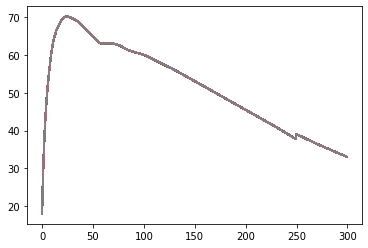

In [14]:
for i in reversed(range(1, 229)):
    olg.update_guess(i)

In [65]:
olg.lmbda_to_price[1,249]

1.348661539231219

In [68]:
t=249
0.5*np.array([olg.i[0,t+1],olg.k[0,t+2],olg.L_share[0,t+1],\
            olg.lmbda_to_price[0,t+1], olg.i[1,t+1],olg.k[1,t+2],\
            olg.lmbda_to_price[1,t+1],\
            olg.w[t+1], olg.price_N[t+1], olg.price[t+1]])+\
            0.5*np.array([olg.i[0,t],olg.k[0,t+1],olg.L_share[0,t],\
            olg.lmbda_to_price[0,t], olg.i[1,t],olg.k[1,t+1],\
            olg.lmbda_to_price[1,t],\
            olg.w[t], olg.price_N[t], olg.price[t]])

array([ 0.06861176,  3.16948031,  0.60866257,  1.26994532,  0.06861121,
        1.82370699,  1.28349722, 23.5044066 ,  0.97563833,  0.97005048])

In [82]:
olg.w[148]

8.582537239123752

In [83]:
olg.history[148]

[     fun: 1.3167890216468667e-17
     info: {'x': array([0.06937677, 3.20596418, 0.44381836, 1.44662514, 0.06937788,
        1.84428038, 1.52187372, 6.96987998, 0.81918051, 0.7612096 ]), 'g': array([], dtype=float64), 'obj_val': 1.3167890216468667e-17, 'mult_g': array([], dtype=float64), 'mult_x_L': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'mult_x_U': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'status': 0, 'status_msg': b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'}
  message: b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
     nfev: 10
      nit: 9
     njev: 11
   status: 0
  success: True
        x: array([0.06937677, 3.20596418, 0.44381836, 1.44662514, 0.06937788,
        1.84428038, 1.52187372, 6.96987998, 0.81918051, 0.7612096 ])]

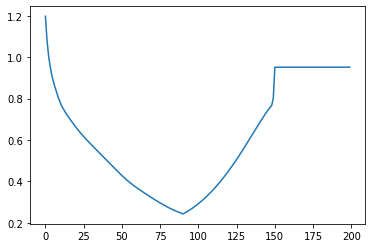

In [78]:
plt.plot(olg.Consumption[:200]/olg.Labor[:200]/olg.A[0,:200])

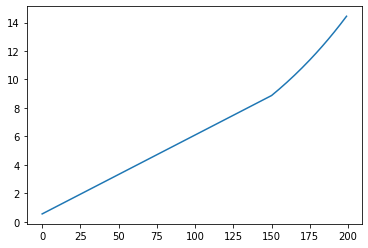

In [32]:
plt.plot(olg.w[:200])

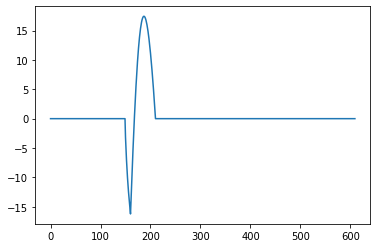

In [46]:
plt.plot(olg.a[0,:,150])

In [45]:
olg.household(0,150,100)

(1.9566893576706055, 0.7650662741534084, 11.769610295671846)

In [13]:
olg.create_guess()

In [3]:
olg.create_guess()

In [5]:
olg.update_guess()

TypeError: update_guess() missing 1 required positional argument: 't'

13.97038559398257
13.97038559398257
13.97038559398257
13.97038559398257


In [42]:
t=0
(1-olg.alpha)*1 *(olg.k[1, t]/(1-olg.L_share[0,t])*olg.A[0,t]/olg.A[1,t])**0.25* olg.A[1, t] 

0.5739835384774816

In [45]:
olg.Labor[0]

13.97038559398257

In [36]:
olg.k[1, t]

0.12039529431235176

In [38]:
(olg.k[1, t]/(1-olg.L_share[0,t]))**olg.alpha

0.8401958128048662

In [37]:
(olg.k[1, t]/(1-olg.L_share[0,t])*olg.A[0,t]/olg.A[1,t])**olg.alpha

0.8401958128048663

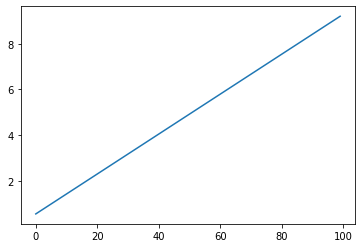

In [22]:
plt.plot(olg.w[0:100])

In [11]:
olg.Consumption[250:350]

array([ 556.42002429,  560.10190598,  563.808151  ,  567.53892059,
        571.29437701,  575.07468364,  578.88000489,  582.7105063 ,
        586.56635448,  590.44771716,  594.35476317,  598.28766245,
        602.24658609,  606.23170628,  610.24319637,  614.28123086,
        618.34598538,  622.43763676,  626.55636296,  630.70234314,
        634.87575766,  639.07678803,  643.305617  ,  647.56242852,
        651.84740774,  656.16074106,  660.5026161 ,  664.87322172,
        669.27274803,  673.7013864 ,  678.15932948,  682.64677116,
        687.16390666,  691.71093245,  696.28804632,  700.89544737,
        705.53333601,  710.20191398,  714.90138435,  719.63195154,
        724.39382133,  729.18720083,  734.01229857,  738.86932441,
        743.75848963,  748.6800069 ,  753.6340903 ,  758.62095531,
        763.64081886,  768.69389931,  773.78041644,  778.90059152,
        784.05464726,  789.24280785,  794.46529898,  799.7223478 ,
        805.01418298,  810.34103472,  815.70313472,  821.10071

In [13]:
810/805

1.0062111801242235

In [64]:
35.92413367/demography['N'][:,:,250].sum()# цель 0.65 

0.616574344522428

In [6]:
olg.evaluate_initial_state()

441.5391345933429
441.5391345933429
441.5391345933429
441.5391345933429


In [11]:
"k_N_steady", "L_N_share",
"k_E_steady", "w_steady",
"price_steady", "price_N_steady"

('price_steady', 'price_N_steady')

In [12]:
demography=np.load('demography.npy', allow_pickle=True).item()

0.8150489457014909

In [48]:
olg.create_guess()

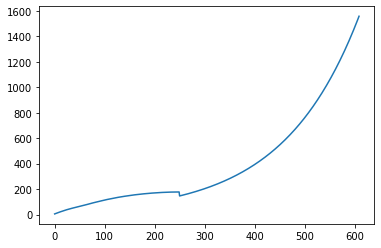

In [56]:
plt.plot(olg.w*olg.Labor*olg.tau_rho/(1+olg.tau_rho + olg.tau_Ins))

In [35]:
olg.VA_sum# + self.I_sum[t]+self.II_sum[t]+self.Ins_sum[t]+self.Rho_sum[t]+self.Pi_sum[t]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [23]:
olg.steady_state()
olg.steady_path[-1]

(     fun: 9.860698309180621e-17
     info: {'x': array([ 4.14947849,  0.82643216,  0.87147639, 22.42212501,  1.00000004,
         1.00000005]), 'g': array([], dtype=float64), 'obj_val': 9.860698309180621e-17, 'mult_g': array([], dtype=float64), 'mult_x_L': array([0., 0., 0., 0., 0., 0.]), 'mult_x_U': array([0., 0., 0., 0., 0., 0.]), 'status': 0, 'status_msg': b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'}
  message: b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
     nfev: 2
      nit: 1
     njev: 3
   status: 0
  success: True
        x: array([ 4.14947849,  0.82643216,  0.87147639, 22.42212501,  1.00000004,
         1.00000005]),
 array([ 4.14937873e+00,  8.26414768e-01,  8.71565246e-01,  2.24221394e+01,
         1.00000130e+00,  1.00000177e+00,  1.24402971e+03,  3.84706709e+01,
        -4.60350340e+04]))

In [22]:
for i in range(10):
    olg.steady_state()
    print(olg.steady_path[-1][0]['success'])

True
True
True
True
True
True
True
True
True
True


In [18]:
(2.61244168e+00/4.96977115e-01)**0.35*4.96977115e-01

0.888351756370893

In [27]:
(3.59554431e+02/2.38258337e+01/19+olg.i_steady*(2.61244168e+00+2.59784231e+00))*0.8

0.9174244994958803

In [12]:
olg.Gov[250]/olg.A[0,250]

369.55613492546206

In [94]:
olg.steady_path

[]

In [25]:
olg.create_guess()

4.514081065421861
4.49981883316465
4.485601662408552
4.471429410781825
4.457301936362546
4.443219097677199
4.429180753699247
4.415186763847732
4.401236987985858
4.3873312864195935
4.373469519896267
4.359651549603178
4.345877237166203
4.332146444648413
4.318459034548689
4.304814869800348
4.291213813769765
4.277655730255017
4.264140483484501
4.2506679381155905
4.237237959233273
4.223850412348797
4.210505163398333
4.197202078741618
4.183941025160635
4.170721869858261
4.15754448045695
4.144408724997401
4.131314471937237
4.118261590149692
4.1052499489222924
4.0922794179555515
4.079349867361662
4.0664611676632
4.053613189791823
4.04080580508698
4.028038885294622
4.015312302565922
4.002625929455987
3.9899796389225886
3.9773733043248867
3.9648067994221634
3.9522799983725583
3.939792775731808
3.927345006451989
3.9149365658802675
3.9025673297576517
3.890237174217743
3.8779459757855
3.865693611376
3.8534799582932084
3.841304894228746
3.829168297260669
3.8170700458522444
3.805010018850735
3.792988

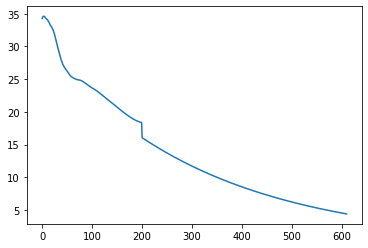

In [26]:
plt.plot(olg.Labor)

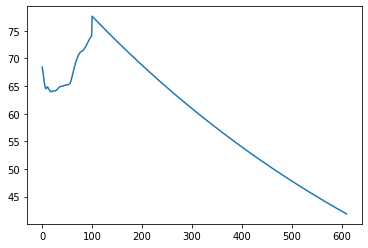

In [11]:
plt.plot(olg.Consumption)

In [52]:
tol = 10e-5
niter = 30

Ищем steady state

In [641]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for _ in tqdm(range(niter),
                  desc = 'Steady state',
                      token=os.getenv('comp_bot_token'),
                      chat_id=os.getenv('chat_id')):
        olg.steady_state()
        if (len(olg.steady_path)>1) and \
            (max(abs(olg.steady_path[-1][1] - olg.steady_path[-2][1]))<tol):
            
                break
olg.update_a_initial()
olg.create_guess()

Steady state:   0%|          | 0/30 [00:00<?, ?it/s]

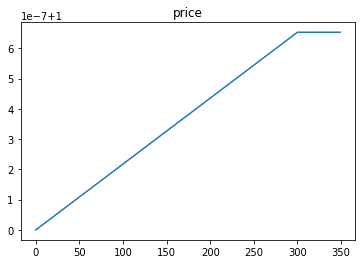

In [642]:
bot = TelegramBot(os.getenv('comp_bot_token'),
                      os.getenv('chat_id'))

plt.plot(olg.price[0:350])
plt.title("price")

bot.send_plot(plt)

# This method delete the generetad image
bot.clean_tmp_dir()

Steady state:   0%|          | 0/299 [00:00<?, ?it/s]

Steady state:   0%|          | 0/299 [00:00<?, ?it/s]

Steady state:   0%|          | 0/299 [00:00<?, ?it/s]

Steady state:   0%|          | 0/299 [00:00<?, ?it/s]

Steady state:   0%|          | 0/299 [00:00<?, ?it/s]

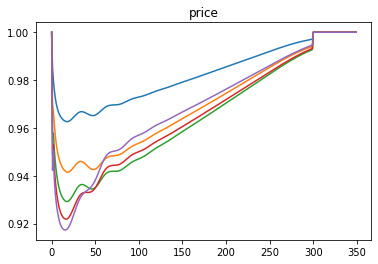

In [420]:
for i in range(5):
    for t in tqdm(reversed(range(1,olg.T)),
                      desc = f'path to steady {i}',
                      total=olg.T-1,
                          token=os.getenv('comp_bot_token'),
                          chat_id=os.getenv('chat_id')):
        olg.update_guess(t)
    plt.plot(olg.price[:(olg.T+50)])
    plt.title("price")

    bot.send_plot(plt)

    bot.clean_tmp_dir()

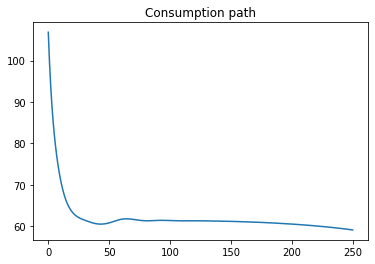

In [643]:
bot = TelegramBot(os.getenv('comp_bot_token'),
                      os.getenv('chat_id'))

plt.plot(olg.Consumption[:251])
plt.title("Consumption path")

bot.send_plot(plt)

# This method delete the generetad image
bot.clean_tmp_dir()

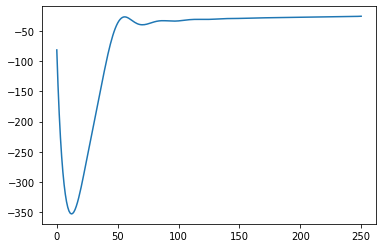

In [627]:
plt.plot(olg.Assets[:251])

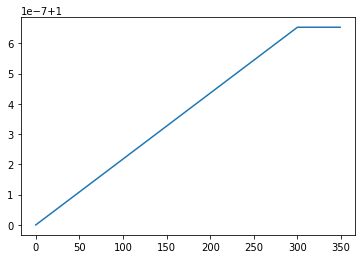

In [625]:
plt.plot(olg.price[:350])

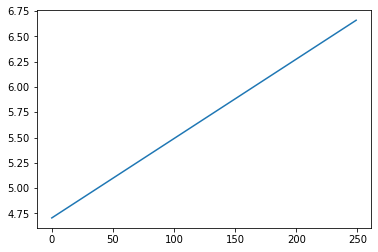

In [626]:
plt.plot(olg.k[0,:250])

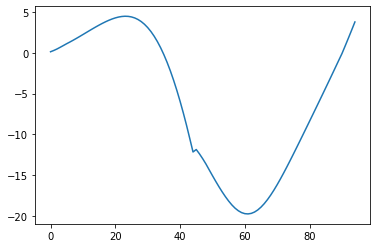

In [498]:
# plt.plot(olg.Pi[0,(45+olg.G-1):45:-1,45])
# plt.plot(olg.c[0,(45+olg.G-1):45:-1,45])
plt.plot(olg.a[0,(45+olg.G-1):45:-1,45])

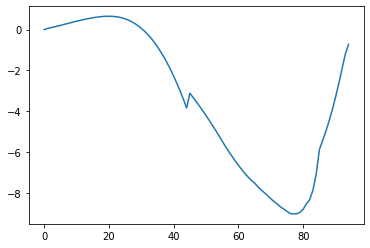

In [515]:
t=0
plt.plot(olg.a[0,(t+olg.G-1):t:-1,t])

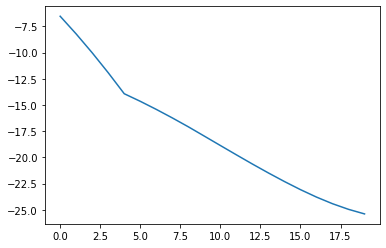

In [494]:
plt.plot(olg.a[0,250,155:251][40:60])
# plt.plot(olg.Pi[0,250,155:251])

In [ ]:
olg.c[0,90:110,45]

In [201]:
high_deficit = np.where(olg.Deficit_ratio[:(olg.T+1)]>0.2)[0]
if len(high_deficit) > 0:
    olg.sigma =np.concatenate((olg.sigma[:high_deficit[0]],
                           np.array([olg.sigma[high_deficit[0]]*0.9 
                                     for _ in range(high_deficit[0],max_time)])))
    if olg.T-olg.G + 1 < high_deficit[0]:
        olg.T = high_deficit[0] + olg.G - 1

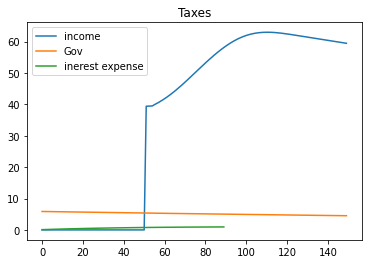

In [537]:
# plt.plot(olg.Gov_Income[200:250])
# Ins_sum  II_sum I_sum VA_sum Pi_sum
plt.plot(olg.Gov_Income[100:250], label = "income")
# plt.plot(olg.Ins_sum[160:250], label = "insurance")
# plt.plot(olg.II_sum[160:250], label = "investment income")
# plt.plot(olg.I_sum[160:250], label = "income")
# plt.plot(olg.VA_sum[160:250], label = "value-added")
# plt.plot(olg.Pi_sum[160:250], label = "profit")
plt.title("Taxes")
# plt.plot(olg.Gov_Outcome[0:250], label = "outcome")
plt.plot(olg.Gov[100:250], label = "Gov")
plt.plot(olg.Debt[160:250]*olg.r[160:250]/olg.Gov_Outcome[160:250], label = "inerest expense")
plt.legend()

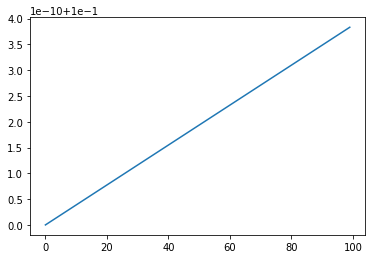

In [210]:
plt.plot(olg.price[:100])

In [214]:
olg.price[100]

0.10000000038709678

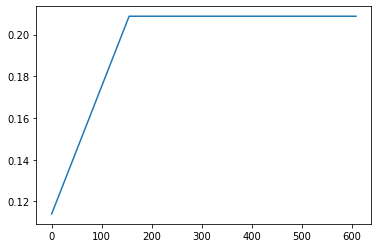

In [221]:
plt.plot(olg.w)

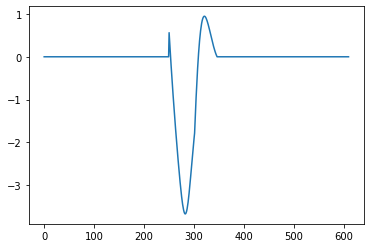

In [215]:
plt.plot(olg.a[0,:,250])

In [25]:
olg.create_guess()

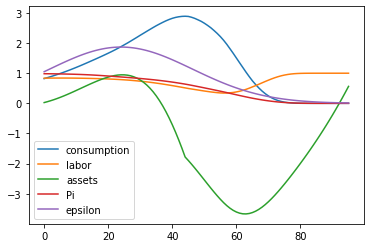

In [216]:
plt.plot(olg.c[0,345:249:-1,250], label = "consumption")
plt.plot(olg.l[0,345:249:-1,250], label = "labor")
plt.plot(olg.a[0,345:249:-1,250], label = "assets")
plt.plot(olg.Pi[0,345:249:-1,250], label = "Pi")
plt.plot(olg.epsilon[0,345:249:-1,250], label ="epsilon")
plt.legend()

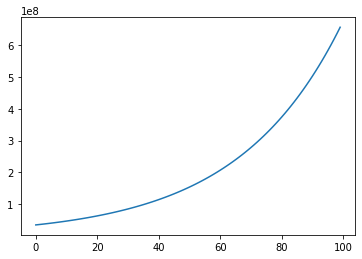

In [179]:
plt.plot(olg.Deficit[150:250])

Text(0.5, 1.0, 'wage adjustment')

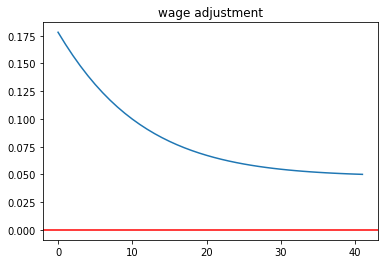

In [173]:
plt.plot([item[1][6] for i, item in enumerate(olg.steady_path)])
# plt.plot([item[1][1] for i, item in enumerate(olg.steady_path)])
plt.axhline(y=0, color='r', linestyle='-')
plt.title("wage adjustment")

Text(0.5, 1.0, 'Labor')

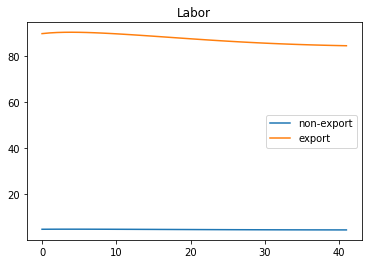

In [174]:
plt.plot([item[1][1]*item[1][-2] for i, item in enumerate(olg.steady_path)], label = "non-export")
plt.plot([(1-item[1][1])*item[1][-2] for i, item in enumerate(olg.steady_path)], label = "export")
plt.legend()
plt.title("Labor")

Text(0.5, 1.0, 'Capital')

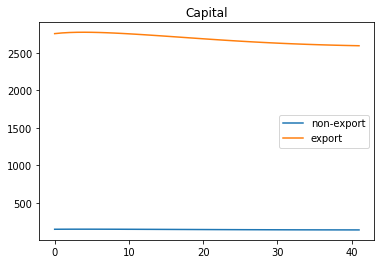

In [175]:
plt.plot([item[1][0]*item[1][-2] for i, item in enumerate(olg.steady_path)], label = "non-export")
plt.plot([item[1][2]*item[1][-2] for i, item in enumerate(olg.steady_path)], label = "export")
plt.legend()
plt.title("Capital")

Text(0.5, 1.0, 'non-export labor share adjustment')

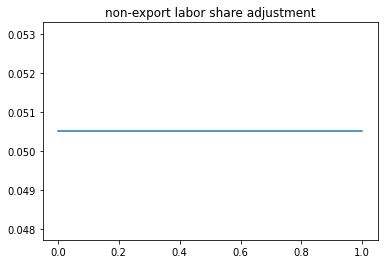

In [217]:
# plt.plot([item[1][0] for i, item in enumerate(olg.steady_path)])
plt.plot([item[1][1] for i, item in enumerate(olg.steady_path)])
plt.title("non-export labor share adjustment")

Text(0.5, 1.0, 'cons adjustment')

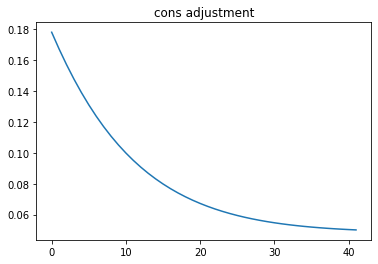

In [177]:
plt.plot([item[1][-3] for i, item in enumerate(olg.steady_path)])
plt.title("cons adjustment")

Text(0.5, 1.0, 'price adjustment')

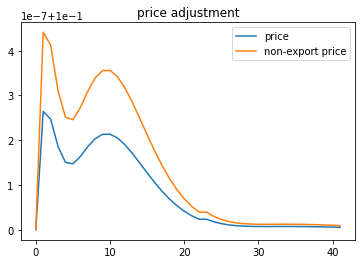

In [178]:
plt.plot([item[1][4] for i, item in enumerate(olg.steady_path)], label ="price")
plt.plot([item[1][5] for i, item in enumerate(olg.steady_path)], label ="non-export price")
plt.legend()
plt.title("price adjustment")

Text(0.5, 1.0, 'Target function')

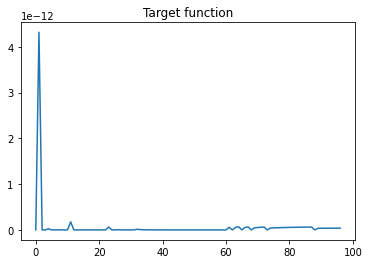

In [163]:
import matplotlib.pyplot as plt
plt.plot([item[0]["fun"] for i, item in enumerate(olg.steady_path)])
plt.title("Target function")

Text(0.5, 1.0, 'k')

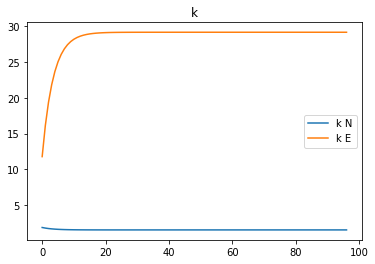

In [164]:
plt.plot([item[1][0] for i, item in enumerate(olg.steady_path)], label ="k N")
plt.plot([item[1][2] for i, item in enumerate(olg.steady_path)], label ="k E")
plt.legend()
plt.title("k")

Text(0.5, 1.0, 'k non-export adjustment')

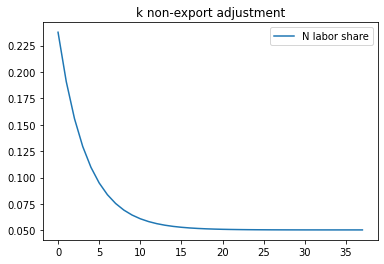

In [152]:
plt.plot([item[1][1] for i, item in enumerate(olg.steady_path)], label ="N labor share")
plt.legend()
plt.title("labor share")

In [279]:
olg.steady_path[-4]
# единственный выход это потребление тоже менять с eta

(     fun: 497133.5107400712
     info: {'x': array([ 6.50888420e+00,  7.89066419e+02,  3.67245615e+04, -8.85181784e-03,
         2.52521567e+01,  3.05824304e+03,  5.72445545e+04,  3.73356679e-02,
         1.81871797e-01,  2.67263830e-08,  2.11897026e-02]), 'g': array([], dtype=float64), 'obj_val': 497133.5107400712, 'mult_g': array([], dtype=float64), 'mult_x_L': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'mult_x_U': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'status': -3, 'status_msg': b'An unrecoverable error occurred while Ipopt tried to compute the search direction.'}
  message: b'An unrecoverable error occurred while Ipopt tried to compute the search direction.'
     nfev: 629
      nit: 21
     njev: 25
   status: -3
  success: False
        x: array([ 6.50888420e+00,  7.89066419e+02,  3.67245615e+04, -8.85181784e-03,
         2.52521567e+01,  3.05824304e+03,  5.72445545e+04,  3.73356679e-02,
         1.81871797e-01,  2.67263830e-08,  2.11897026e-02]),
 array

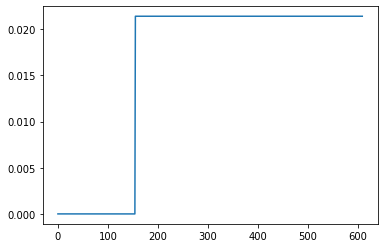

In [38]:
import matplotlib.pyplot as plt
plt.plot(olg.w)

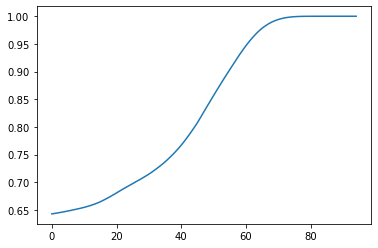

In [606]:
# plt.plot(olg.c[0][345-30,(250-30):(345-30)]) # труд у дрпугих неправильно рассчитывается?
# plt.plot(olg.l[0][345-30,(250-30):(345-30)])


In [43]:
olg.w[99]

1.3201810425347083e-05

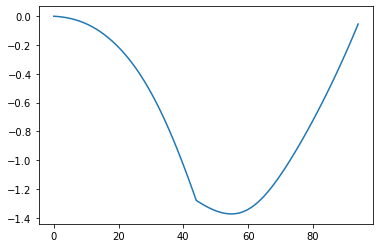

In [25]:
# plt.plot(olg.l[0][260,165:260], label= "labor")
# plt.plot(olg.c[0][260,165:260], label = "consumption")
plt.plot(olg.a[0][260,165:260], label = "assets")
# plt.plot((olg.c[0][260,165:260]**olg.phi * (1-olg.l[0][260,165:260])**(1-olg.phi))**(1-olg.theta)/(1-olg.theta), label = "utility")
plt.show()

Text(0.5, 1.0, 'Wage path')

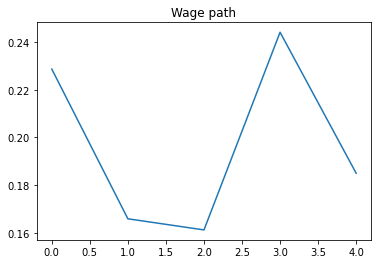

In [614]:
plt.plot([item[0]["info"]["x"][8] for i, item in enumerate(olg.steady_path)if i != 1] [0:])
plt.title("Wage path")

Text(0.5, 1.0, 'Price N path')

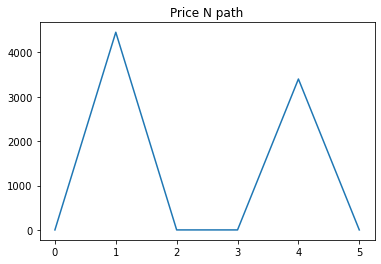

In [615]:
plt.plot([item[0]["info"]["x"][10] for item in olg.steady_path][0:])
plt.title("Price N path")

In [ ]:
import matplotlib.pyplot as plt
# plt.plot((((olg.c[:,:610,:]*olg.N[:,:610,:]).sum(axis=0).sum(axis=0))/olg.N[:,:610,:].sum(axis=0).sum(axis=0))[:150])
# plt.plot((((olg.a[:,:610,:]*olg.N[:,:610,:]).sum(axis=0).sum(axis=0))/olg.N[:,:610,:].sum(axis=0).sum(axis=0))[:150])
plt.plot((((olg.l[:,:610,:]*olg.N[:,:610,:]).sum(axis=0).sum(axis=0))/olg.N[:,:610,:].sum(axis=0).sum(axis=0))[:250])
# plt.plot(olg.I[0,:100]/olg.N[0].sum(axis=0)[:100])
# plt.plot((olg.l[0,:250]*olg.N[0,:250]).sum(axis=0)/(olg.N[0,:250].sum(axis=0)))
plt.show()

In [ ]:
plt.plot(olg.I[0,1:100]/olg.I[0,0:99])

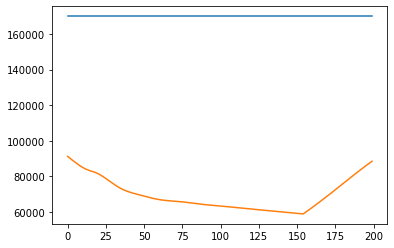

In [616]:
plt.plot(olg.L[0][:200]+olg.L[1][:200])
plt.plot(((olg.l[:,:610,:]*olg.N[:,:610,:]*olg.epsilon[:,:610,:]).sum(axis=0).sum(axis=0))[:200])

In [331]:
olg.L[0][:200]+olg.L[1][:200]

array([170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 1700

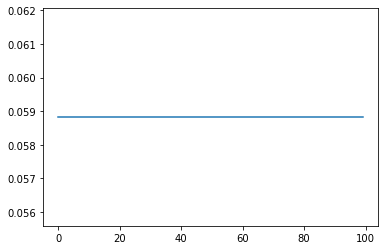

In [332]:
plt.plot((olg.K[0]/olg.L[0])[:100])

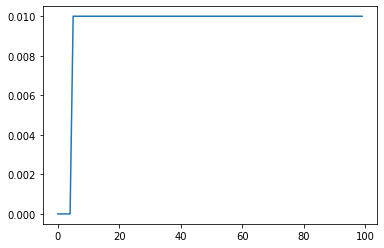

In [44]:
plt.plot(olg.a[0][100][:100])

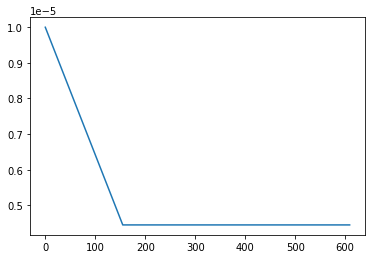

In [45]:
plt.plot(olg.price_N)

In [54]:
olg.w[120]

1.2925927310610548e-05

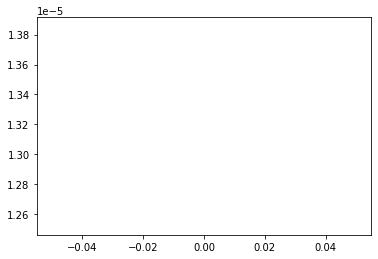

In [49]:
plt.plot(olg.w[100])